In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samithsachidanandan/human-face-emotions")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'human-face-emotions' dataset.
Path to dataset files: /kaggle/input/human-face-emotions


In [2]:
import os
import shutil

# 1. Tentukan path Anda
original_base_dir = '/kaggle/input/human-face-emotions/Data'
new_base_dir = '/kaggle/working/Data_3_Class' # Kita buat di direktori 'working'

# 2. Tentukan pemetaan kelas kita
# Key = nama folder baru, Value = list folder lama
class_mapping = {
    'Positive': ['Happy'],
    'Negative': ['Angry', 'Fear', 'Sad'],
    'Neutral': ['Suprise']
}

print(f"Membuat struktur 3 kelas di: {new_base_dir}")

# 3. Loop dan salin file
for new_class, old_folders in class_mapping.items():

    # Buat folder baru (e.g., /kaggle/working/Data_3_Class/Positive)
    new_class_path = os.path.join(new_base_dir, new_class)
    os.makedirs(new_class_path, exist_ok=True)

    print(f"Memproses folder: {new_class}")

    # Loop melalui folder-folder lama yang akan digabung
    for old_folder in old_folders:
        old_folder_path = os.path.join(original_base_dir, old_folder)

        # Salin setiap gambar dari folder lama ke folder baru
        for filename in os.listdir(old_folder_path):
            src_file = os.path.join(old_folder_path, filename)
            dst_file = os.path.join(new_class_path, filename)
            shutil.copy(src_file, dst_file)

print("\nSelesai! Struktur data 3 kelas telah dibuat.")

Membuat struktur 3 kelas di: /kaggle/working/Data_3_Class
Memproses folder: Positive
Memproses folder: Negative
Memproses folder: Neutral

Selesai! Struktur data 3 kelas telah dibuat.


In [24]:
import tensorflow as tf

base_dir = '/kaggle/working/Data_3_Class'
BATCH_SIZE = 64
SEED = 123
TARGET_SIZE = (48, 48)

print("Membuat training dataset (tf.data)...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,       # Ttap 20%
    subset="training",
    seed=SEED,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'      #  grayscale
)

print("Membuat validation dataset (tf.data)...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

# Cek nama kelas
print(f"Kelas yang ditemukan: {train_ds.class_names}")


# fungsi normalisasi
def normalize_img(image, label):
  """Normalisasi gambar ke [0,1]"""
  return tf.cast(image, tf.float32) / 255., label

train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nPipeline data tf.data siap dengan prefetching!")

Membuat training dataset (tf.data)...
Found 59093 files belonging to 3 classes.
Using 47275 files for training.
Membuat validation dataset (tf.data)...
Found 59093 files belonging to 3 classes.
Using 11818 files for validation.
Kelas yang ditemukan: ['Negative', 'Neutral', 'Positive']

Pipeline data tf.data siap dengan prefetching!


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = Sequential(
  [
    RandomFlip("horizontal"),
    RandomRotation(0.1),
  ],
  name="data_augmentation"
)

model = Sequential([
    Input(shape=(48, 48, 1)),
    data_augmentation,

    # Blok 1
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Blok 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Blok 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Blok 4
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Flatten dan Dense
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,299 (1.19 MB)

 Trainable params: 309,571 (1.18 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [40]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# --- 1. EarlyStopping  ---
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# --- 2. ModelCheckpoint  ---
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# --- 3. ReduceLROnPlateau ---
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Gabungkan semua callback
my_callbacks = [early_stopping, checkpoint, lr_scheduler]

# --- Kompilasi Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Class Weights  ---
class_weights_dict = {
    0: 0.88,  # Negative
    1: 2.01,  # Neutral
    2: 1.36   # Positive
}

print("Callback siap: EarlyStopping (5 epoch), Checkpoint (Save Best), & LR Scheduler.")

Callback siap: EarlyStopping (5 epoch), Checkpoint (Save Best), & LR Scheduler.


In [41]:
EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=my_callbacks
)

Epoch 1/50
737/739 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9101 - loss: 0.2834
Epoch 1: val_accuracy improved from -inf to 0.85463, saving model to best_model.keras
739/739 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9101 - loss: 0.2835 - val_accuracy: 0.8546 - val_loss: 0.4097 - learning_rate: 0.0010
Epoch 2/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8994 - loss: 0.3069
Epoch 2: val_accuracy improved from 0.85463 to 0.85861, saving model to best_model.keras
739/739 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8994 - loss: 0.3069 - val_accuracy: 0.8586 - val_loss: 0.3885 - learning_rate: 0.0010
Epoch 3/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9030 - loss: 0.3068
Epoch 3: val_accuracy did not improve from 0.85861
739/739 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.9030 - loss: 0.3068 - val_accuracy: 0.8115 - val_loss: 0.5660 - learning_rate: 0.0010
Epoch 4/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9011 - loss: 0.30

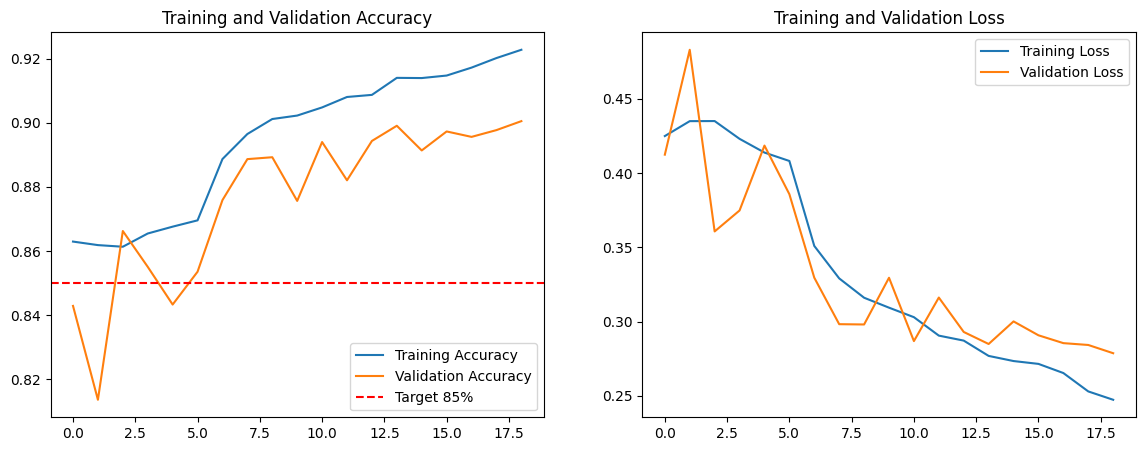

In [31]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc)) # Jumlah epoch yang telah berjalan

# Membuat plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Menambahkan garis target
plt.axhline(y=0.85, color='r', linestyle='--', label='Target 85%')
if 0.90 in acc or 0.90 in val_acc: # Jika Anda mencapai
    plt.axhline(y=0.90, color='g', linestyle='--', label='Target 90%')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Membuat plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input

class_names = ['Negative', 'Neutral', 'Positive']
print(f"Kelas dataset: {class_names}")

# 2.  Model Inference (Tanpa Augmentasi)
print("Membuat model khusus inference...")
inference_model = Sequential()

#  Input Layer dengan bentuk yang pasti
inference_model.add(Input(shape=(48, 48, 1), name="input_image"))

for layer in model.layers[1:]:
    inference_model.add(layer)

print("Model inference berhasil dibuat.")
inference_model.summary()

Kelas dataset: ['Negative', 'Neutral', 'Positive']
Membuat model khusus inference...
Model inference berhasil dibuat.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,299 (1.19 MB)

 Trainable params: 309,571 (1.18 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [42]:
import os
import subprocess

os.makedirs('submission/tflite', exist_ok=True)
os.makedirs('submission/saved_model', exist_ok=True)
os.makedirs('submission/tfjs_model', exist_ok=True)

export_dir = 'submission/saved_model'
inference_model.export(export_dir)
print(f"✅ SavedModel disimpan di: {export_dir}")

tflite_model_path = 'submission/tflite/model.tflite'

# Konversi dari SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Tulis file
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"✅ TF-Lite model disimpan di: {tflite_model_path}")

# Simpan Label
with open('submission/tflite/label.txt', 'w') as f:
    for label in class_names:
        f.write(label + '\n')
print("✅ Label TFLite disimpan.")

print("Menginstal tensorflowjs...")
subprocess.run(['pip', 'install', '-q', 'tensorflowjs'], capture_output=True)

h5_path = 'submission/model.h5'
inference_model.save(h5_path)

# Jalankan konversi
print("Mengonversi ke TFJS...")
!tensorflowjs_converter --input_format=keras {h5_path} submission/tfjs_model

print("✅ TFJS model disimpan di: submission/tfjs_model")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='input_image')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135696022243856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135696022242896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135696022242128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135696022249040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135696022241552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135696022241936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135696022241744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135696022242704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135696022243664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135696022256720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13569602225

Mengonversi ke TFJS...
2025-11-23 04:51:36.484837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763873496.519484   18723 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763873496.530365   18723 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763873496.558116   18723 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763873496.558163   18723 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763873496.558172   18723 computation_placer.cc:177]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


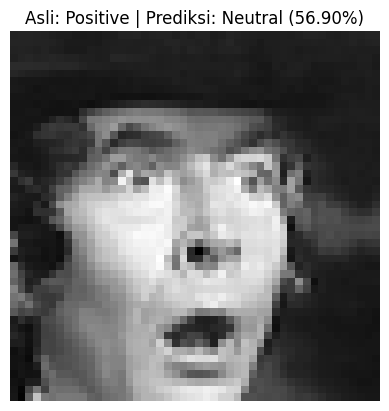

Hasil Prediksi: Neutral


In [43]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Ambil satu gambar sampel dari folder 'Positive'
sample_dir = '/kaggle/working/Data_3_Class/Neutral'
sample_file = os.listdir(sample_dir)[9]
sample_path = os.path.join(sample_dir, sample_file)

# Muat dan Preprocess
img = image.load_img(sample_path, target_size=(48, 48), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi menggunakan inference_model
predictions = inference_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
predicted_class = class_names[np.argmax(score)]

# Tampilkan Hasil
plt.imshow(img, cmap='gray')
plt.title(f"Asli: Positive | Prediksi: {predicted_class} ({100 * np.max(score):.2f}%)")
plt.axis('off')
plt.show()

print(f"Hasil Prediksi: {predicted_class}")

In [45]:
import os
import shutil

# --- 1. Pastikan requirements.txt ada ---
req_content = """tensorflow
numpy
matplotlib
pillow
kagglehub
tensorflowjs
pandas
"""
with open('requirements.txt', 'w') as f:
    f.write(req_content)
print("✅ File requirements.txt siap.")

# --- 2. Membuat File ZIP ---
# Perintah ini akan men-zip folder 'submission' dan file 'requirements.txt'
# Nama file outputnya adalah 'submission_final.zip'
print("⏳ Sedang membuat file zip...")
!zip -r submission_final.zip submission requirements.txt

# Cek ukuran file
file_size = os.path.getsize('submission_final.zip') / (1024 * 1024)
print(f"✅ File ZIP berhasil dibuat! Ukuran: {file_size:.2f} MB")

# --- 3. Download Otomatis (Khusus Google Colab) ---
try:
    from google.colab import files
    print("⬇️ Memulai download...")
    files.download('submission_final.zip')
except ImportError:
    print("\n⚠️ Anda sepertinya menggunakan Kaggle atau Local Jupyter.")
    print("Silakan cari file 'submission_final.zip' di menu 'Output' atau 'Files' di sebelah kanan/kiri layar Anda dan download manual.")

✅ File requirements.txt siap.
⏳ Sedang membuat file zip...
  adding: submission/ (stored 0%)
  adding: submission/tflite/ (stored 0%)
  adding: submission/tflite/label.txt (deflated 4%)
  adding: submission/tflite/model.tflite (deflated 11%)
  adding: submission/saved_model/ (stored 0%)
  adding: submission/saved_model/fingerprint.pb (stored 0%)
  adding: submission/saved_model/assets/ (stored 0%)
  adding: submission/saved_model/saved_model.pb (deflated 88%)
  adding: submission/saved_model/variables/ (stored 0%)
  adding: submission/saved_model/variables/variables.index (deflated 72%)
  adding: submission/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: submission/tfjs_model/ (stored 0%)
  adding: submission/tfjs_model/group1-shard1of1.bin (deflated 7%)
  adding: submission/tfjs_model/model.json (deflated 92%)
  adding: submission/model.h5 (deflated 12%)
  adding: requirements.txt (deflated 12%)
✅ File ZIP berhasil dibuat! Ukuran: 4.73 MB
⬇️ Memulai downloa

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>